El siguiente código tiene el objetivo de hacer backtesting basado en factores. El factor principal que voy a recoger es *momentum*, este será medido en base a retornos. Dentro de un universo de activos, escoger las acciones que han tenido un rendimiento medido en retornos más alto. Esto supone que debemos surfear la ola de expectativa que existe en cierto activo en el corto plazo. Por supuesto, debemos evitar penny stocks que tienden a liderar estas listas. 

In [70]:
import numpy as np
import os
import warnings
import pandas as pd
from zipline import run_algorithm
from zipline.api import (
    attach_pipeline,
    calendars,
    date_rules,
    get_datetime,
    get_open_orders,
    order_target_percent,
    pipeline_output,
    record,
    schedule_function,
    set_benchmark,
    set_commission,
    set_slippage,
    symbol,
    time_rules,
)
from zipline.data import bundles
from zipline.finance import commission, slippage
from zipline.pipeline import CustomFactor, Pipeline
from zipline.pipeline.factors import VWAP, AverageDollarVolume, Returns
from zipline.utils.run_algo import load_extensions
from zipline.errors import SymbolNotFound
warnings.filterwarnings("ignore")
from zipline.pipeline.factors import CustomFactor
from zipline.pipeline.data import USEquityPricing

In [11]:
import os
from zipline.data import bundles

os.environ["QUANDL_API_KEY"] = "exUAmDyTRNiz3b76Dx6Q"
bundle = "quandl"
bundles.ingest(bundle)

Couldn't compute ratio for dividend sid=67, ex_date=2017-11-09, amount=0.620
Couldn't compute ratio for dividend sid=93, ex_date=2017-11-09, amount=0.240
Couldn't compute ratio for dividend sid=161, ex_date=2017-11-09, amount=0.110
Couldn't compute ratio for dividend sid=283, ex_date=2017-11-09, amount=0.415
Couldn't compute ratio for dividend sid=298, ex_date=2017-11-09, amount=1.420
Couldn't compute ratio for dividend sid=318, ex_date=2017-11-09, amount=0.330
Couldn't compute ratio for dividend sid=434, ex_date=2017-11-09, amount=0.110
Couldn't compute ratio for dividend sid=516, ex_date=1996-05-30, amount=0.310
Couldn't compute ratio for dividend sid=524, ex_date=2017-11-09, amount=0.050
Couldn't compute ratio for dividend sid=556, ex_date=2017-11-09, amount=0.075
Couldn't compute ratio for dividend sid=578, ex_date=2017-11-09, amount=0.160
Couldn't compute ratio for dividend sid=605, ex_date=2017-11-09, amount=0.040
Couldn't compute ratio for dividend sid=666, ex_date=1990-03-26, a

In [51]:
MONTH = 21
N_LONGS = 50
VOL_SCREEN = 100

In [142]:
class Momentum(CustomFactor): 
    
    inputs = [USEquityPricing.close, Returns(window_length=126)]
    window_length = MONTH
    window_length = 126
    
    def compute(self, today, assets, out, prices, returns):
        
        out[:] = (
            (prices[-7] - prices[-42]) / prices[-42]
            - (prices[-1] - prices[-7]) / prices[-7]
        ) / np.nanstd(returns, axis=0)

In [143]:
def make_pipeline():
    momentum = Momentum()
    dollar_volume = AverageDollarVolume(window_length=30)
    return Pipeline(
        columns={
            "factor" : momentum,
            "longs" : momentum.top(N_LONGS),
            "shorts" : momentum.bottom(N_LONGS),
            "ranking" : momentum.rank(ascending=False),
        }, 
        screen=dollar_volume.top(VOL_SCREEN),
    )

In [144]:
def before_trading_start(context, data): 
    context.factor_data = pipeline_output("factor_pipeline")
    print(context.factor_data)

In [145]:
def initialize(context): 
    attach_pipeline(make_pipeline(), "factor_pipeline")
    schedule_function(
        rebalance,
        date_rules.week_start(),
        time_rules.market_open(),
        calendar=calendars.US_EQUITIES,
    )

In [146]:
def rebalance(context, data): 
    factor_data = context.factor_data
    record(factor_data=factor_data.ranking)
    assets = factor_data.index
    record(prices=data.current(assets, "price"))
    longs = assets[factor_data.longs]
    shorts = assets[factor_data.shorts]
    divest = set(
        context.portfolio.positions.keys()) - set(longs.union(shorts))
    
    exec_trades(
        data, 
        assets=divest, 
        target_percent=0
    )
    
    exec_trades(
        data, 
        assets=longs, 
        target_percent=1 / N_LONGS
    )
    
    exec_trades(
        data, 
        assets=shorts, 
        target_percent = -1 / N_LONGS
        
    )
    
    

In [147]:
def exec_trades(data, assets, target_percent): 
    for asset in assets: 
        if data.can_trade(asset) and not get_open_orders(asset): 
            order_target_percent(asset, target_percent)
            

In [148]:
start = pd.Timestamp("2016-01-01")
end = pd.Timestamp("2018-01-01")
perf = run_algorithm(
    start=start,
    end=end,
    initialize=initialize,
    capital_base=100_000,
    before_trading_start=before_trading_start,
    bundle="quandl",
)

                       factor  longs  shorts  ranking
Equity(2 [AAL])     -0.591241  False   False   1724.0
Equity(8 [AAPL])    -0.973101  False   False   2061.0
Equity(12 [ABBV])   -0.966694  False   False   2051.0
Equity(71 [AET])    -0.350272  False   False   1452.0
Equity(85 [AGN])    -0.211270  False   False   1270.0
...                       ...    ...     ...      ...
Equity(3077 [WFC])  -0.050293  False   False   1057.0
Equity(3101 [WMB])  -2.138090  False   False   2575.0
Equity(3105 [WMT])   1.234297  False   False    203.0
Equity(3156 [XOM])  -1.923554  False   False   2509.0
Equity(3172 [YHOO]) -0.057731  False   False   1069.0

[100 rows x 4 columns]
                       factor  longs  shorts  ranking
Equity(2 [AAL])     -0.134051  False   False   1670.0
Equity(8 [AAPL])    -0.859871  False   False   2283.0
Equity(12 [ABBV])   -0.362212  False   False   1921.0
Equity(71 [AET])    -0.059468  False   False   1595.0
Equity(85 [AGN])     0.151090  False   False   1318.0
... 

<Axes: >

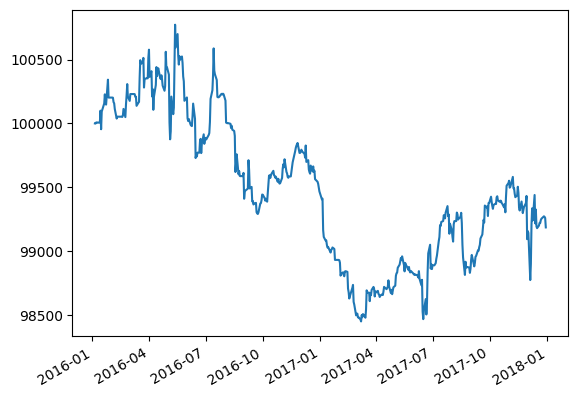

In [149]:
perf.portfolio_value.plot()